In [1]:
# import stuff
import os
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm_notebook as tqdm
from sklearn import model_selection

import torch
import torch.utils.data as data
from itertools import product as product

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Function

import librosa

# Any results you write to the current directory are saved as output.
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms,models
from tqdm import tqdm_notebook as tqdm
from torch.optim import lr_scheduler

import sklearn.metrics

In [2]:
os.makedirs("log", exist_ok=True)
os.makedirs("models", exist_ok=True)

In [3]:
batch_size = 8
watermark = "resnet18"
model_name = watermark
CONTINUE = False

# define directories
base_dir = "./"
esc_dir = os.path.join(base_dir, "ESC-50-master")
meta_file = os.path.join(esc_dir, "meta/esc50.csv")
audio_dir = os.path.join(esc_dir, "audio/")

# load metadata
meta_data = pd.read_csv(meta_file)

# save train?
SAVE_DATA = True

wave size:(220500,)
melsp size:(128, 1723)
samping rate:44100


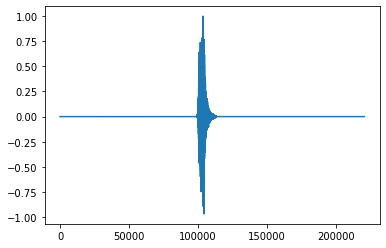

no display


In [4]:
# load a wave data
def load_wave_data(audio_dir, file_name):
    file_path = os.path.join(audio_dir, file_name)
    x, fs = librosa.load(file_path, sr=44100)
    return x,fs

# change wave data to mel-stft
def calculate_melsp(x, n_fft=1024, hop_length=128):
    stft = np.abs(librosa.stft(x, n_fft=n_fft, hop_length=hop_length))**2
    log_stft = librosa.power_to_db(stft)
    melsp = librosa.feature.melspectrogram(S=log_stft,n_mels=128)
    return melsp

# display wave in plots
def show_wave(x):
    plt.plot(x)
    plt.show()

# display wave in heatmap
def show_melsp(melsp, fs):
    librosa.display.specshow(melsp, sr=fs)
    plt.colorbar()
    plt.show()

# example data
x, fs = load_wave_data(audio_dir, meta_data.loc[0,"filename"])
melsp = calculate_melsp(x)
print("wave size:{0}\nmelsp size:{1}\nsamping rate:{2}".format(x.shape, melsp.shape, fs))
show_wave(x)
try:
    show_melsp(melsp, fs)
except:
    print("no display")

# setup dataloaders

In [5]:
# define directories
base_dir = "./"
esc_dir = os.path.join(base_dir, "ESC-50-master")
meta_file = os.path.join(esc_dir, "meta/esc50.csv")
audio_dir = os.path.join(esc_dir, "audio/")

# load metadata
meta_data = pd.read_csv(meta_file)

In [6]:
# data augmentation: add white noise
def add_white_noise(x, rate=0.002):
    return x + rate*np.random.randn(len(x))

# data augmentation: shift sound in timeframe
def shift_sound(x, rate=2):
    return np.roll(x, int(len(x)//rate))

# data augmentation: stretch sound
def stretch_sound(x, rate=1.1):
    input_length = len(x)
    x = librosa.effects.time_stretch(x, rate)
    if len(x)>input_length:
        return x[:input_length]
    else:
        return np.pad(x, (0, max(0, input_length - len(x))), "constant")

In [7]:
class ESC50Dataset(Dataset):
    def __init__(self, data, label, data_aug=False, _type='train'):
        self.label = label
        self.data_aug = data_aug
        self.data = data
        
    def __len__(self):
        return len(self.label)
    
    def __getitem__(self,idx):
        label = self.label[idx]
        x, fs = load_wave_data(audio_dir, self.data[idx])
        
        # augumentations in wave domain.
        if self.data_aug:
            r = np.random.rand()
            if r < 0.3:
                x = add_white_noise(x)

            r = np.random.rand()
            if r < 0.3:
                x = shift_sound(x, rate=1+np.random.rand())

            r = np.random.rand()
            if r < 0.3:
                x = stretch_sound(x, rate=0.8+np.random.rand()*0.4)
        
        # convert to melsp
        melsp = calculate_melsp(x)
        
        # normalize
        mean = np.mean(melsp)
        std = np.std(melsp)
        
        melsp -= mean
        melsp /= std
        
        melsp = np.asarray([melsp, melsp, melsp])
        return melsp, label

In [8]:
# get training dataset and target dataset
x = list(meta_data.loc[:,"filename"])
y = list(meta_data.loc[:, "target"])

x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.25, stratify=y, random_state=42)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


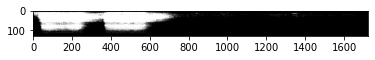

In [9]:
traindataset = ESC50Dataset(x_train, y_train, data_aug=True)
testdataset = ESC50Dataset(x_test, y_test, data_aug=False)
train_loader = torch.utils.data.DataLoader(traindataset, batch_size=batch_size,shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(testdataset, batch_size=batch_size,shuffle=True, num_workers=0)

mel, label = traindataset[0]
plt.imshow(mel.transpose([1,2,0]))

# setup model

In [10]:
# backbone
import pretrainedmodels
basemodel = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')
basemodel = nn.Sequential(*list(basemodel.children())[:-2])

In [11]:
# # backbone
# import pretrainedmodels
# basemodel = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')
# basemodel = nn.Sequential(*list(basemodel.children())[:-2])
# print(basemodel)
# input = torch.rand([1,3,128,1723])
# print(type(input))
# print(basemodel(input).shape)

In [12]:
class mymodel(nn.Module):
    def __init__(self):
        super(mymodel, self).__init__()
        self.features = basemodel
        if model_name == "resnet34" or model_name == "resnet18":
            num_ch = 512
        else:
            num_ch = 2048
        self.fc = nn.Conv2d(num_ch, 50, 1)
        self.pool = nn.AdaptiveAvgPool2d(1)
        

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = self.fc(x).squeeze(2).squeeze(2)
        return x

In [13]:
# class mymodel(nn.Module):
#     def __init__(self):
#         super(mymodel, self).__init__()
#         self.features = basemodel
#         if model_name == "resnet34" or model_name == "resnet18":
#             num_ch = 512
#         else:
#             num_ch = 2048
#         self.fc = nn.Conv2d(num_ch, 50, 1)
#         self.pool = nn.AdaptiveAvgPool2d(1)
#         self.rnn = nn.GRU(4*54, 128, 2, batch_first=True, bidirectional=True)
#         self.sed = nn.Sequential(
#             nn.Linear(512*256, 1024),
#             nn.ReLU(),
#             nn.Linear(1024, 50)
#         )

#     def forward(self, x):
#         x = self.features(x)
#         x = x.reshape(x.shape[0],x.shape[1], -1)
#         print(x.shape)
#         x ,_= self.rnn(x)
#         print(x.shape)
#         x = x.reshape(x.shape[0], -1)
#         x = self.sed(x)
#         # x = self.pool(x)
#         # x = self.fc(x).squeeze(2).squeeze(2)
#         return x

In [14]:
model = mymodel()
input = torch.rand([1,3,128,1723])
model(input).size()

torch.Size([1, 50])

# optimizers

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = mymodel().to(device)
optimizer = optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
epochs = 100 # original 50

exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True, min_lr=1e-3*1e-4, factor=0.33)

# train loop

In [16]:
def train(epoch):
    model.train()
    print('epochs {}/{} '.format(epoch+1,epochs))
    running_loss = 0.0
    running_acc = 0.0
    acc = 0.0

    t = tqdm(train_loader)
    
    for idx, (inputs,labels) in enumerate(t):       
        # send to gpu
        inputs = inputs.to(device)
        labels = labels.to(device)
     
        # set opt
        optimizer.zero_grad()
        
        # run model
        outputs = model(inputs.float())
            
        loss = criterion(outputs,labels)
        # misc
        running_loss += loss
        running_acc += (outputs.argmax(1)==labels).float().mean()
        acc += (outputs.argmax(1)==labels).float().mean()
        loss.backward()
        optimizer.step()
        
        t.set_description(f't (l={running_loss/(idx+1):.4f})(a1={acc/(idx+1):.4f})')
        if idx%8==7:
            rd = np.random.rand()
        
    #scheduler.step()
    losses.append(running_loss/len(train_loader))
    accs.append(running_acc/(len(train_loader)))
    print('train acc : {:.2f}%'.format(running_acc/(len(train_loader))))
    print('train loss : {:.4f}'.format(running_loss/len(train_loader)))
    print('dev acc1 : {:.2f}%'.format(acc/(len(train_loader))))
    
    # save logs
    log_epoch = {'epoch': epoch+1, 'lr': optimizer.state_dict()['param_groups'][0]['lr'],
                     'loss': running_loss/len(train_loader), "acc1": acc/(len(train_loader))}
    logs.append(log_epoch)
    df = pd.DataFrame(logs)
    df.to_csv("log/log_output_train_{}.csv".format(watermark))
    

In [17]:
def eval(epoch):
    model.eval()
    print('epochs {}/{} '.format(epoch+1,epochs))
    running_loss = 0.0
    running_acc = 0.0
    acc = 0.0

    t = tqdm(test_loader)
    
    for idx, (inputs,labels) in enumerate(t):       
        # send to gpu
        inputs = inputs.to(device)
        labels = labels.to(device)
     
        # set opt
        optimizer.zero_grad()
        
        with torch.no_grad():
            # run model
            outputs = model(inputs.float())
            
        loss = criterion(outputs,labels)
        # misc
        running_loss += loss
        running_acc += (outputs.argmax(1)==labels).float().mean()
        acc += (outputs.argmax(1)==labels).float().mean()
        #loss.backward()
        #optimizer.step()
        
        t.set_description(f't (l={running_loss/(idx+1):.4f})(a1={acc/(idx+1):.4f})')
        if idx%8==7:
            rd = np.random.rand()
        
    #scheduler.step()
    losses.append(running_loss/len(test_loader))
    accs.append(running_acc/(len(test_loader)))
    print('eval acc : {:.2f}%'.format(running_acc/(len(test_loader))))
    print('eval loss : {:.4f}'.format(running_loss/len(test_loader)))
    print('dev acc1 : {:.2f}%'.format(acc/(len(test_loader))))
    
    # save logs
    log_epoch = {'epoch': epoch+1, 'lr': optimizer.state_dict()['param_groups'][0]['lr'],
                     'loss': running_loss/len(test_loader), "acc1": acc/(len(test_loader))}
    logs_eval.append(log_epoch)
    df = pd.DataFrame(logs_eval)
    df.to_csv("log/log_output_eval_{}.csv".format(watermark))
    

In [18]:
import gc
logs = []
logs_eval = []
losses = []
accs = []
logs = []
start = 0
epochs = 100

if CONTINUE:
    #start = START
    model.load_state_dict(torch.load("./models/cutonly_se_resnext50_32x4d_cutmix_236_29epochs_saved_weights.pth"))

for epoch in range(start, epochs):
    torch.cuda.empty_cache()
    train(epoch)
    torch.cuda.empty_cache()
    eval(epoch)
    if epoch %10==0:
        torch.save(model.state_dict(), './models/{}_{}epochs_saved_weights.pth'.format(watermark, epoch))
    # GC
    torch.cuda.empty_cache()
    gc.collect()
    

epochs 1/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.29%
train loss : 2.8734
dev acc1 : 0.29%
epochs 1/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.62%
eval loss : 1.5259
dev acc1 : 0.62%
epochs 2/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.61%
train loss : 1.6335
dev acc1 : 0.61%
epochs 2/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.75%
eval loss : 0.9424
dev acc1 : 0.75%
epochs 3/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.76%
train loss : 1.0906
dev acc1 : 0.76%
epochs 3/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.83%
eval loss : 0.7259
dev acc1 : 0.83%
epochs 4/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.83%
train loss : 0.8000
dev acc1 : 0.83%
epochs 4/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.86%
eval loss : 0.5586
dev acc1 : 0.86%
epochs 5/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.88%
train loss : 0.5999
dev acc1 : 0.88%
epochs 5/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.85%
eval loss : 0.6116
dev acc1 : 0.85%
epochs 6/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.91%
train loss : 0.4542
dev acc1 : 0.91%
epochs 6/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.84%
eval loss : 0.5726
dev acc1 : 0.84%
epochs 7/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.92%
train loss : 0.3998
dev acc1 : 0.92%
epochs 7/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.88%
eval loss : 0.4450
dev acc1 : 0.88%
epochs 8/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.94%
train loss : 0.2937
dev acc1 : 0.94%
epochs 8/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.88%
eval loss : 0.4583
dev acc1 : 0.88%
epochs 9/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.95%
train loss : 0.2448
dev acc1 : 0.95%
epochs 9/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.89%
eval loss : 0.4180
dev acc1 : 0.89%
epochs 10/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.96%
train loss : 0.2118
dev acc1 : 0.96%
epochs 10/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.87%
eval loss : 0.4564
dev acc1 : 0.87%
epochs 11/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.97%
train loss : 0.2058
dev acc1 : 0.97%
epochs 11/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.86%
eval loss : 0.5437
dev acc1 : 0.86%
epochs 12/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.97%
train loss : 0.1687
dev acc1 : 0.97%
epochs 12/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.91%
eval loss : 0.3536
dev acc1 : 0.91%
epochs 13/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.97%
train loss : 0.1584
dev acc1 : 0.97%
epochs 13/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.89%
eval loss : 0.4349
dev acc1 : 0.89%
epochs 14/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.98%
train loss : 0.1248
dev acc1 : 0.98%
epochs 14/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.88%
eval loss : 0.4823
dev acc1 : 0.88%
epochs 15/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.97%
train loss : 0.1541
dev acc1 : 0.97%
epochs 15/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.84%
eval loss : 0.6485
dev acc1 : 0.84%
epochs 16/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.98%
train loss : 0.1257
dev acc1 : 0.98%
epochs 16/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.86%
eval loss : 0.5347
dev acc1 : 0.86%
epochs 17/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.98%
train loss : 0.0968
dev acc1 : 0.98%
epochs 17/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.88%
eval loss : 0.4318
dev acc1 : 0.88%
epochs 18/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.98%
train loss : 0.1143
dev acc1 : 0.98%
epochs 18/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.88%
eval loss : 0.4291
dev acc1 : 0.88%
epochs 19/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.98%
train loss : 0.1082
dev acc1 : 0.98%
epochs 19/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.87%
eval loss : 0.4839
dev acc1 : 0.87%
epochs 20/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.99%
train loss : 0.0819
dev acc1 : 0.99%
epochs 20/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.89%
eval loss : 0.4622
dev acc1 : 0.89%
epochs 21/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.98%
train loss : 0.0848
dev acc1 : 0.98%
epochs 21/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.85%
eval loss : 0.6035
dev acc1 : 0.85%
epochs 22/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.98%
train loss : 0.1145
dev acc1 : 0.98%
epochs 22/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.87%
eval loss : 0.4991
dev acc1 : 0.87%
epochs 23/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.98%
train loss : 0.1127
dev acc1 : 0.98%
epochs 23/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.84%
eval loss : 0.5748
dev acc1 : 0.84%
epochs 24/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.97%
train loss : 0.1198
dev acc1 : 0.97%
epochs 24/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.88%
eval loss : 0.5333
dev acc1 : 0.88%
epochs 25/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.98%
train loss : 0.0875
dev acc1 : 0.98%
epochs 25/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.88%
eval loss : 0.5113
dev acc1 : 0.88%
epochs 26/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.98%
train loss : 0.0806
dev acc1 : 0.98%
epochs 26/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.84%
eval loss : 0.6678
dev acc1 : 0.84%
epochs 27/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.99%
train loss : 0.0731
dev acc1 : 0.99%
epochs 27/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.86%
eval loss : 0.5939
dev acc1 : 0.86%
epochs 28/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.99%
train loss : 0.0678
dev acc1 : 0.99%
epochs 28/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.89%
eval loss : 0.4706
dev acc1 : 0.89%
epochs 29/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.98%
train loss : 0.0677
dev acc1 : 0.98%
epochs 29/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.88%
eval loss : 0.4638
dev acc1 : 0.88%
epochs 30/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.98%
train loss : 0.0797
dev acc1 : 0.98%
epochs 30/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.88%
eval loss : 0.5603
dev acc1 : 0.88%
epochs 31/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.98%
train loss : 0.0949
dev acc1 : 0.98%
epochs 31/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.88%
eval loss : 0.5205
dev acc1 : 0.88%
epochs 32/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.99%
train loss : 0.0473
dev acc1 : 0.99%
epochs 32/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.88%
eval loss : 0.4728
dev acc1 : 0.88%
epochs 33/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.99%
train loss : 0.0449
dev acc1 : 0.99%
epochs 33/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.88%
eval loss : 0.4894
dev acc1 : 0.88%
epochs 34/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.98%
train loss : 0.0805
dev acc1 : 0.98%
epochs 34/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.86%
eval loss : 0.5237
dev acc1 : 0.86%
epochs 35/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.99%
train loss : 0.0554
dev acc1 : 0.99%
epochs 35/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.88%
eval loss : 0.4379
dev acc1 : 0.88%
epochs 36/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.99%
train loss : 0.0527
dev acc1 : 0.99%
epochs 36/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.85%
eval loss : 0.5934
dev acc1 : 0.85%
epochs 37/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.99%
train loss : 0.0606
dev acc1 : 0.99%
epochs 37/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.88%
eval loss : 0.4749
dev acc1 : 0.88%
epochs 38/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.98%
train loss : 0.0861
dev acc1 : 0.98%
epochs 38/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.89%
eval loss : 0.4403
dev acc1 : 0.89%
epochs 39/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.99%
train loss : 0.0627
dev acc1 : 0.99%
epochs 39/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.87%
eval loss : 0.6292
dev acc1 : 0.87%
epochs 40/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.99%
train loss : 0.0360
dev acc1 : 0.99%
epochs 40/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.91%
eval loss : 0.3368
dev acc1 : 0.91%
epochs 41/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 1.00%
train loss : 0.0173
dev acc1 : 1.00%
epochs 41/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.89%
eval loss : 0.3846
dev acc1 : 0.89%
epochs 42/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.98%
train loss : 0.0868
dev acc1 : 0.98%
epochs 42/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.83%
eval loss : 0.7901
dev acc1 : 0.83%
epochs 43/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.99%
train loss : 0.0470
dev acc1 : 0.99%
epochs 43/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.86%
eval loss : 0.5620
dev acc1 : 0.86%
epochs 44/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.99%
train loss : 0.0407
dev acc1 : 0.99%
epochs 44/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.89%
eval loss : 0.4512
dev acc1 : 0.89%
epochs 45/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.99%
train loss : 0.0329
dev acc1 : 0.99%
epochs 45/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.85%
eval loss : 0.6067
dev acc1 : 0.85%
epochs 46/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.99%
train loss : 0.0490
dev acc1 : 0.99%
epochs 46/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.89%
eval loss : 0.4835
dev acc1 : 0.89%
epochs 47/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.99%
train loss : 0.0454
dev acc1 : 0.99%
epochs 47/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.87%
eval loss : 0.6387
dev acc1 : 0.87%
epochs 48/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.98%
train loss : 0.0672
dev acc1 : 0.98%
epochs 48/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.88%
eval loss : 0.5337
dev acc1 : 0.88%
epochs 49/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.98%
train loss : 0.0785
dev acc1 : 0.98%
epochs 49/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.86%
eval loss : 0.5144
dev acc1 : 0.86%
epochs 50/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.99%
train loss : 0.0542
dev acc1 : 0.99%
epochs 50/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.86%
eval loss : 0.6106
dev acc1 : 0.86%
epochs 51/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.99%
train loss : 0.0594
dev acc1 : 0.99%
epochs 51/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.88%
eval loss : 0.5473
dev acc1 : 0.88%
epochs 52/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.99%
train loss : 0.0469
dev acc1 : 0.99%
epochs 52/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.89%
eval loss : 0.4741
dev acc1 : 0.89%
epochs 53/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.99%
train loss : 0.0585
dev acc1 : 0.99%
epochs 53/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.85%
eval loss : 0.7745
dev acc1 : 0.85%
epochs 54/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.98%
train loss : 0.0599
dev acc1 : 0.98%
epochs 54/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.88%
eval loss : 0.5402
dev acc1 : 0.88%
epochs 55/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.99%
train loss : 0.0409
dev acc1 : 0.99%
epochs 55/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.91%
eval loss : 0.4337
dev acc1 : 0.91%
epochs 56/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.99%
train loss : 0.0426
dev acc1 : 0.99%
epochs 56/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.88%
eval loss : 0.5855
dev acc1 : 0.88%
epochs 57/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.99%
train loss : 0.0407
dev acc1 : 0.99%
epochs 57/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.88%
eval loss : 0.5631
dev acc1 : 0.88%
epochs 58/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.99%
train loss : 0.0256
dev acc1 : 0.99%
epochs 58/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.89%
eval loss : 0.5024
dev acc1 : 0.89%
epochs 59/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.99%
train loss : 0.0414
dev acc1 : 0.99%
epochs 59/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.88%
eval loss : 0.4928
dev acc1 : 0.88%
epochs 60/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.99%
train loss : 0.0538
dev acc1 : 0.99%
epochs 60/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.87%
eval loss : 0.5785
dev acc1 : 0.87%
epochs 61/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_26912/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

KeyboardInterrupt: 